<a href="https://colab.research.google.com/github/memozzeyman/EyeRecycle/blob/main/eye_recycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [7]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

In [8]:
from google.colab import files
uploaded = files.upload()

Saving dataset-resized.zip to dataset-resized.zip


In [43]:

files = zf.ZipFile("dataset-resized.zip",'r')
files.extractall()
files.close()

In [44]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['cardboard', '.DS_Store', 'trash', 'metal', 'plastic', 'glass', 'paper']

In [11]:
# helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [12]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [13]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [14]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

In [15]:
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: /content/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: /content/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data

In [16]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


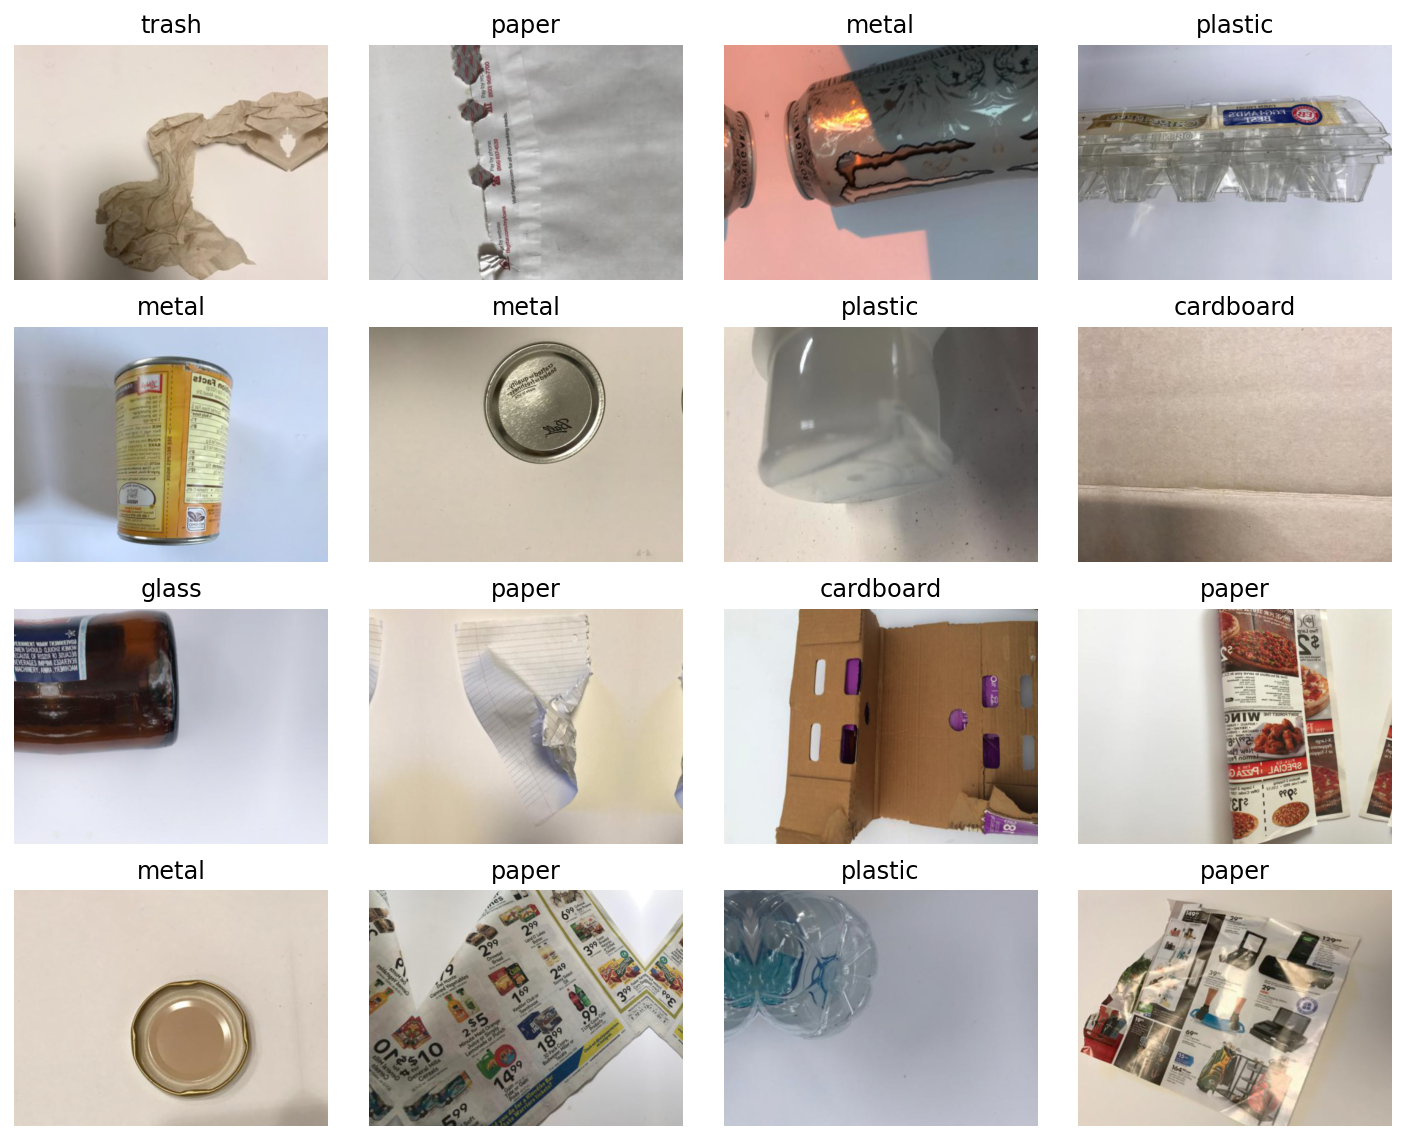

In [17]:
data.show_batch(rows=4,figsize=(10,8))

In [18]:
learn = create_cnn(data,models.resnet34,metrics=error_rate)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [19]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


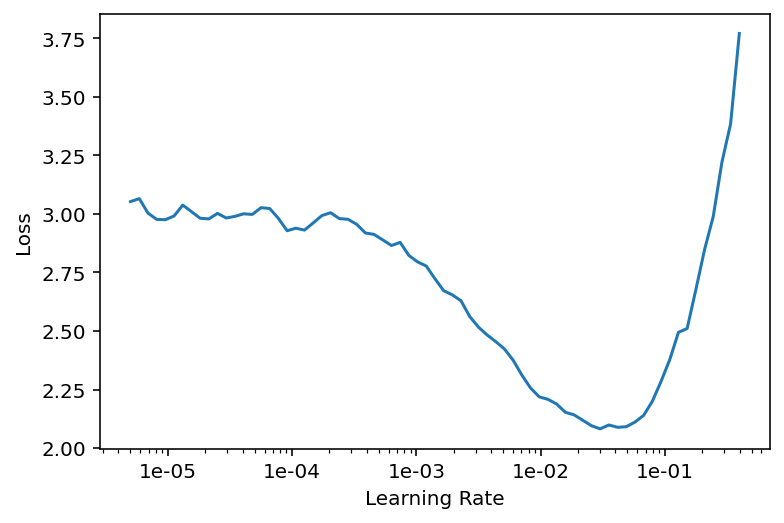

In [20]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

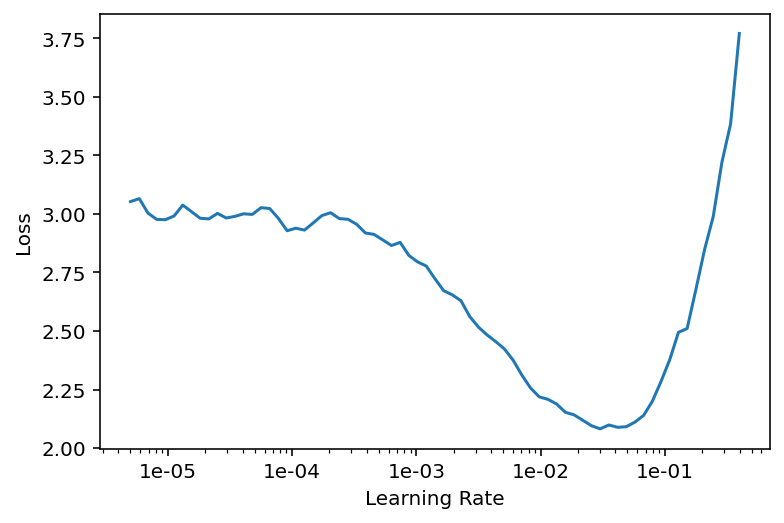

In [21]:
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(20,max_lr=5.13e-03)

epoch,train_loss,valid_loss,error_rate,time
0,1.685589,0.669074,0.234921,00:36
1,1.111671,0.510240,0.146032,00:35
2,0.880949,0.539514,0.152381,00:36
3,0.834842,1.168107,0.263492,00:36
4,0.843160,0.781664,0.225397,00:36
5,0.818896,0.525683,0.149206,00:36
6,0.781902,0.612102,0.185714,00:36
7,0.708095,0.475232,0.138095,00:36
8,0.619655,0.730121,0.188889,00:36
9,0.561494,0.432721,0.134921,00:36


In [23]:
learn.export(os.path.abspath('./eye_recycle_trained_model.pkl'))

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

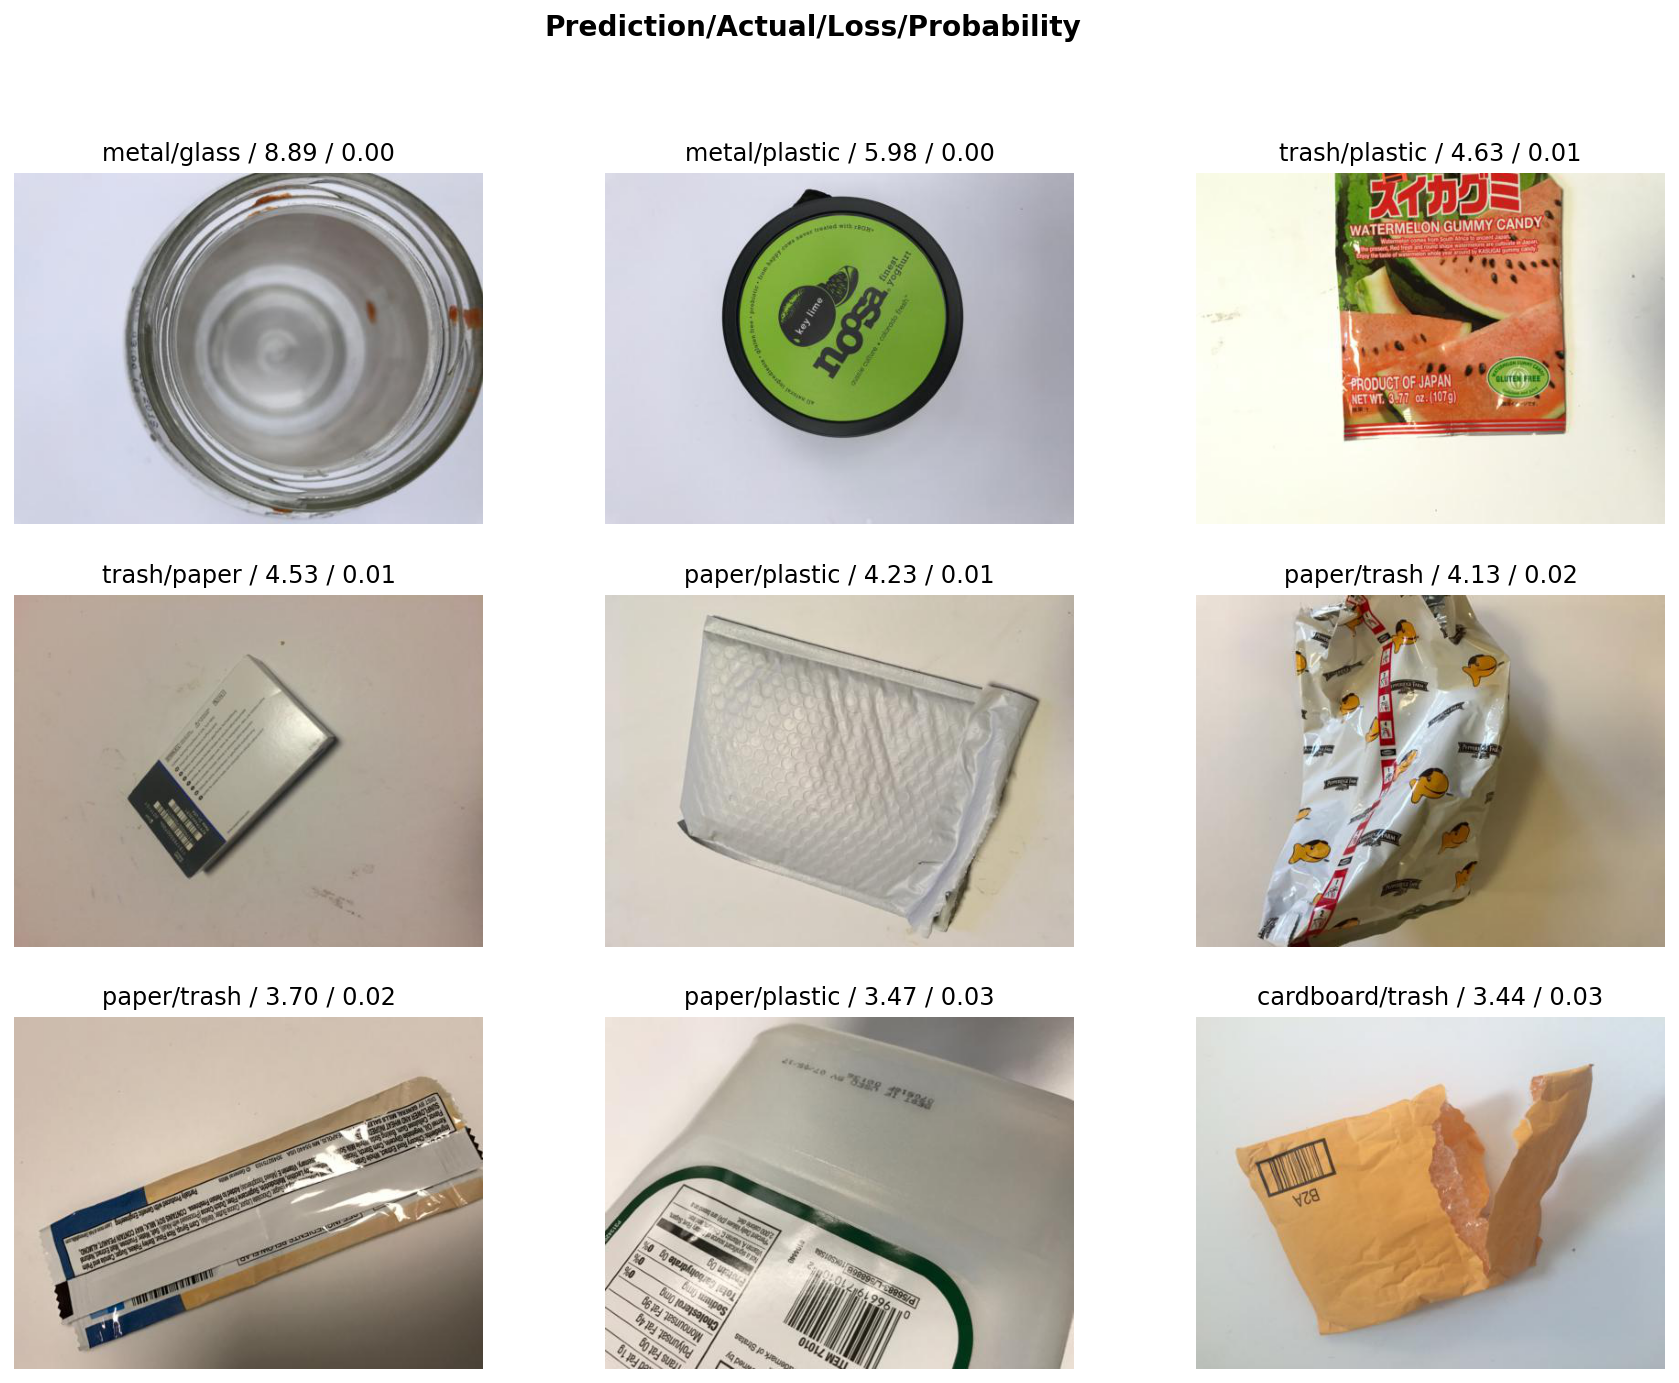

In [25]:
interp.plot_top_losses(9, figsize=(15,11))

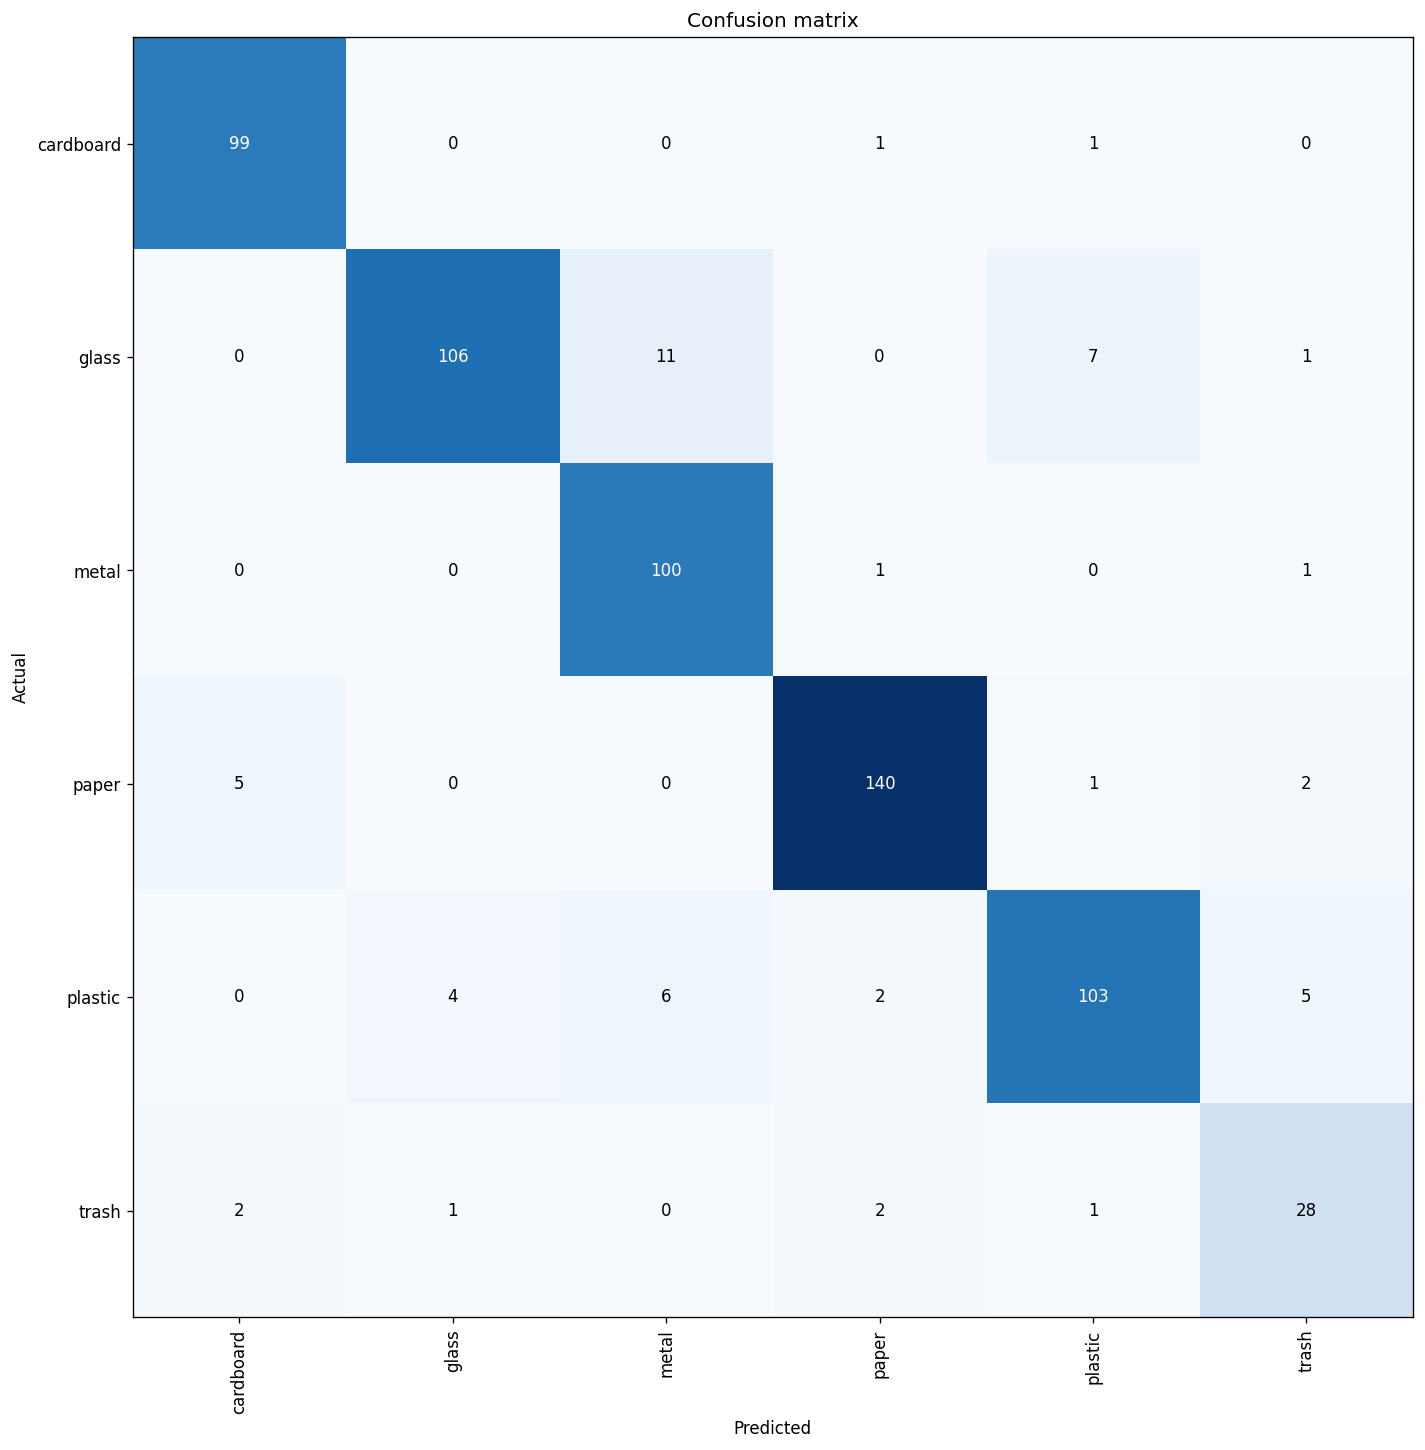

In [26]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [27]:
interp.most_confused(min_val=2)

[('glass', 'metal', 11),
 ('glass', 'plastic', 7),
 ('plastic', 'metal', 6),
 ('paper', 'cardboard', 5),
 ('plastic', 'trash', 5),
 ('plastic', 'glass', 4),
 ('paper', 'trash', 2),
 ('plastic', 'paper', 2),
 ('trash', 'cardboard', 2),
 ('trash', 'paper', 2)]

In [28]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [29]:
print(preds[0].shape)
preds[0]

torch.Size([635, 6])


tensor([[3.3478e-04, 4.6025e-06, 2.7548e-09, 9.9966e-01, 7.4130e-07, 3.1055e-07],
        [5.0189e-06, 2.0651e-04, 2.4778e-03, 1.3892e-06, 9.9731e-01, 1.1925e-07],
        [7.1595e-05, 3.5153e-06, 2.7586e-06, 9.9922e-01, 6.0751e-04, 9.2315e-05],
        ...,
        [9.8954e-05, 8.4329e-05, 1.0048e-03, 3.6259e-05, 9.9872e-01, 5.4227e-05],
        [4.7802e-08, 9.9999e-01, 3.1951e-06, 1.5233e-08, 6.2798e-06, 2.1997e-08],
        [1.7017e-02, 4.8444e-04, 7.9644e-06, 9.8124e-01, 1.2451e-03, 2.9723e-06]])

In [30]:
data.classes 

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [31]:
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [32]:
yhat = []
for max_idx in max_idxs:
  yhat.append(data.classes[max_idx])

In [33]:
yhat

['paper',
 'plastic',
 'paper',
 'glass',
 'trash',
 'paper',
 'paper',
 'plastic',
 'glass',
 'cardboard',
 'paper',
 'metal',
 'paper',
 'metal',
 'metal',
 'plastic',
 'plastic',
 'trash',
 'paper',
 'glass',
 'plastic',
 'paper',
 'trash',
 'glass',
 'trash',
 'cardboard',
 'cardboard',
 'metal',
 'cardboard',
 'metal',
 'metal',
 'cardboard',
 'glass',
 'glass',
 'cardboard',
 'glass',
 'trash',
 'cardboard',
 'paper',
 'cardboard',
 'metal',
 'cardboard',
 'plastic',
 'paper',
 'paper',
 'glass',
 'cardboard',
 'cardboard',
 'trash',
 'metal',
 'paper',
 'glass',
 'plastic',
 'cardboard',
 'glass',
 'trash',
 'glass',
 'paper',
 'plastic',
 'plastic',
 'paper',
 'plastic',
 'trash',
 'trash',
 'plastic',
 'plastic',
 'plastic',
 'paper',
 'plastic',
 'metal',
 'glass',
 'plastic',
 'plastic',
 'cardboard',
 'glass',
 'metal',
 'plastic',
 'paper',
 'paper',
 'cardboard',
 'metal',
 'trash',
 'glass',
 'cardboard',
 'paper',
 'cardboard',
 'metal',
 'cardboard',
 'cardboard',
 'pa

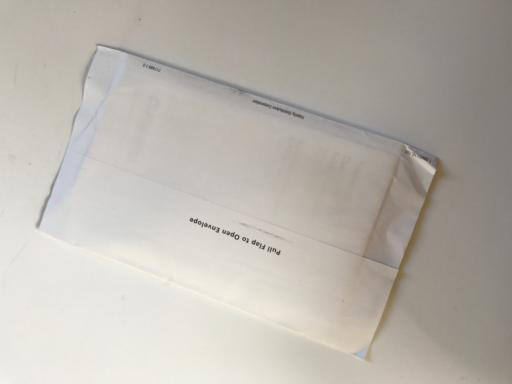

In [34]:
learn.data.test_ds[0][0]

In [35]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [36]:


## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['paper', 'plastic', 'paper', 'glass', 'trash']
['paper', 'plastic', 'paper', 'glass', 'trash']


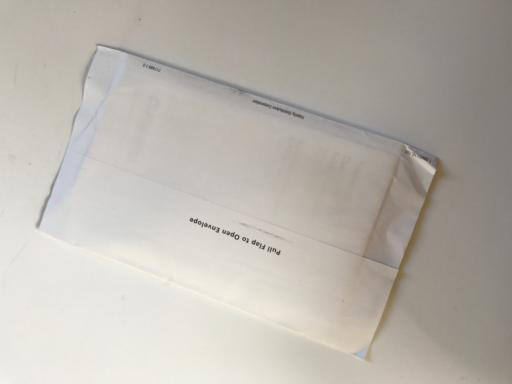

In [37]:
learn.data.test_ds[0][0]

In [38]:
learn.export(os.path.abspath('./my_export.pkl'))

# New section

In [39]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 97   0   1   3   0   0]
 [  0 109   9   0   8   0]
 [  0   2  99   0   1   1]
 [  3   0   1 143   0   2]
 [  0   3   0   0 115   3]
 [  2   1   0   2   1  29]]


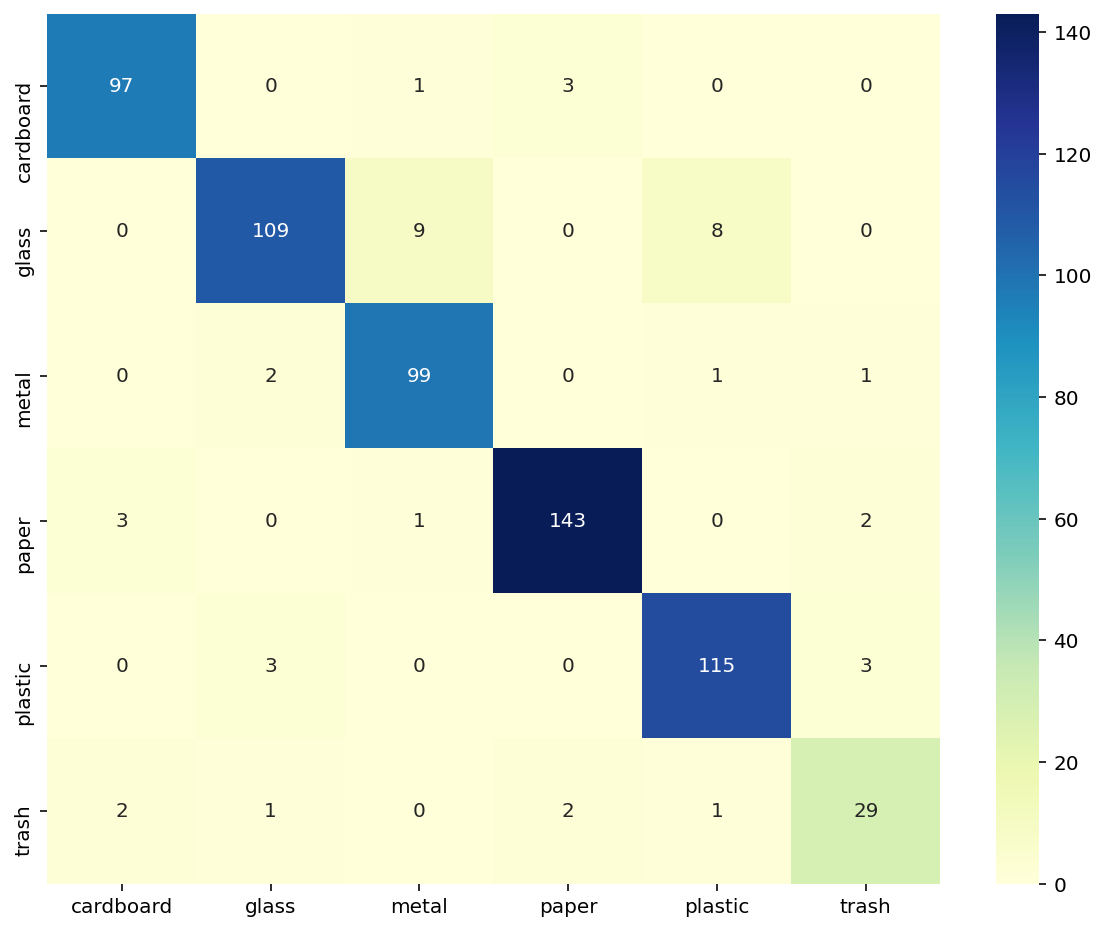

In [40]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [41]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [42]:
accuracy = correct/sum(sum(cm))
accuracy

0.9322834645669291

91% accuracy achieved on this dataset, this is an extremely good score, most models of this nature may achieve on average 65% accuracy, further improvement may erradicate future errors. 